# Plot mooring data (thermistors)

In [1]:
import os
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from scipy.interpolate import interp1d
from datetime import datetime
import cmocean


%matplotlib widget 

### Parameters

Specify the path to the data folder and the date of the campaigns to combine:

In [2]:
data_folder='../data/Mooring/HOBO_T'
date_campaigns=['20240527','20240910','20241126'] 

Define the depth values of the grid:

In [3]:
depth_grid=np.arange(0,26,0.1)

Define the variables:

In [4]:
time_num=np.array([])
temp_grid=np.array([])

### Load the Level-3 data and combine all the periods

In [5]:
for k,camp in enumerate(date_campaigns):
    foldername=os.path.join(data_folder,camp,'Level3')
    filename=os.listdir(foldername)
    if len(filename)>1:
        raise Exception("Too many data files!")
    filename=filename[0]
    nc=netCDF4.Dataset(os.path.join(foldername,filename))
    time_num=np.concatenate((time_num,nc.variables["time"][:].data),axis=0)
    depth=nc.variables["depth"][:].data
    temp=nc.variables["temp"][:].data
    f=interp1d(nc.variables["depth"][:].data,nc.variables["temp"][:].data,axis=0,kind='linear',bounds_error=False, fill_value=np.nan)
    if len(temp_grid)==0:
        temp_grid=f(depth_grid)
        temp_sensors=np.copy(temp)
        depth_sensors=np.copy(depth)
    else:
        temp_interp=f(depth_grid)
        temp_grid=np.concatenate((temp_grid,f(depth_grid)),axis=1)
        temp_add=np.full((len(depth_sensors),len(nc.variables["time"][:].data)),np.nan)
        temp_add[[d in depth for d in depth_sensors],:]=temp[[d in depth_sensors for d in depth],:]
        temp_sensors=np.concatenate((temp_sensors,temp_add),axis=1)
        ind_newsensors=np.where([d not in depth_sensors for d in depth])[0]
        if len(ind_newsensors)>0:
            depth_sensors=np.concatenate((depth_sensors,depth[ind_newsensors]), axis=0)
            nan_temp=np.full((len(ind_newsensors),len(time_num)-len(nc.variables["time"][:].data)),np.nan)
            temp_sensors=np.concatenate((temp_sensors,np.concatenate((nan_temp,temp[ind_newsensors,:]),axis=1)),axis=0)     
    nc.close()

time_date=time_num.astype("datetime64[s]").astype(datetime)

### 1. Plot time series at each sensor depth

Text(0, 0.5, 'Temp (°C)')

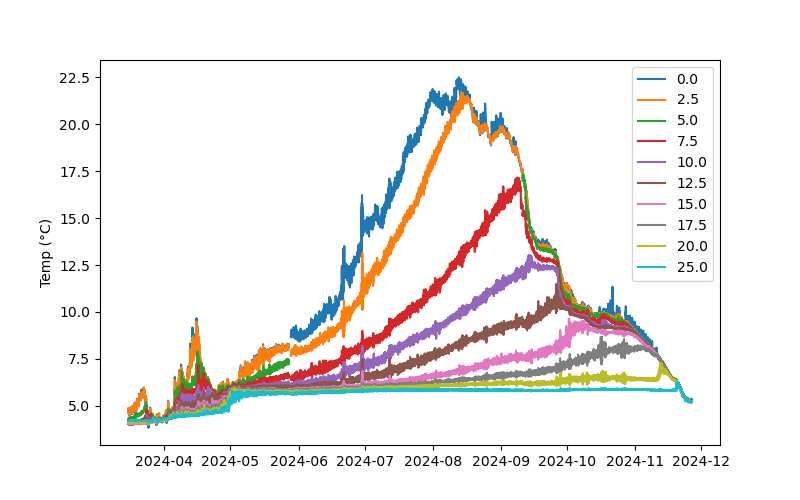

In [6]:
fig1,ax=plt.subplots(1,1,figsize=(8,5))
for kd in range(len(depth_sensors)):
    ax.plot(time_date,temp_sensors[kd,:])
lg=ax.legend(depth_sensors)
ax.set_ylabel('Temp (°C)')

### 2. Plot temperature grid

Text(0, 0.5, 'Depth (m)')

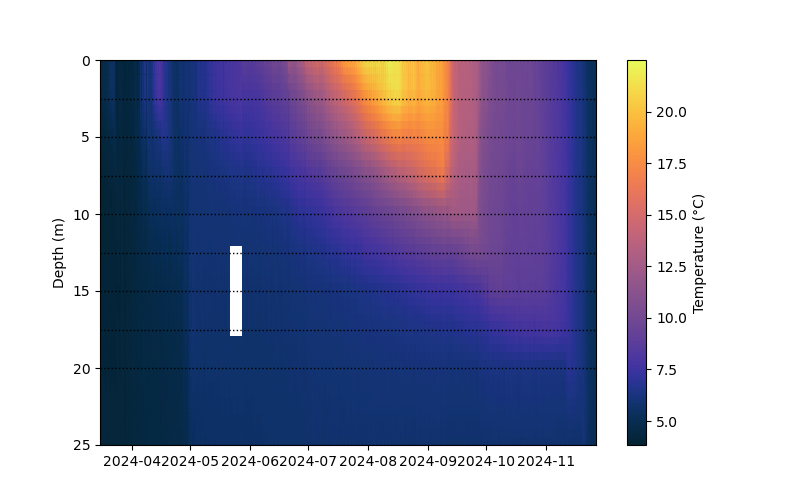

In [12]:
fig2,ax=plt.subplots(1,1,figsize=(8,5))
hp=ax.pcolormesh(time_date,depth_grid,temp_grid,cmap=cmocean.cm.thermal)
for d in depth_sensors:
    ax.plot([time_date[0],time_date[-1]],[d,d],':k',linewidth=1)
cb=plt.colorbar(hp)
cb.set_label("Temperature (°C)")
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')

### Export the figures

In [8]:
fig1.savefig(os.path.join("Figures","mooring_time_series.png"),dpi=400)
fig2.savefig(os.path.join("Figures","mooring_grid.png"),dpi=400)